In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from tqdm import trange , tqdm
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as T
import numpy as np
from torchmetrics.classification import MulticlassJaccardIndex
from torchmetrics.segmentation import DiceScore
from torch.cuda.amp import autocast, GradScaler
from torch import amp



/tmp/ipykernel_36/119321072.py:32: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter([], [], c=np.array(color)/255, s=1000, label=f"{class_id}: {name}")


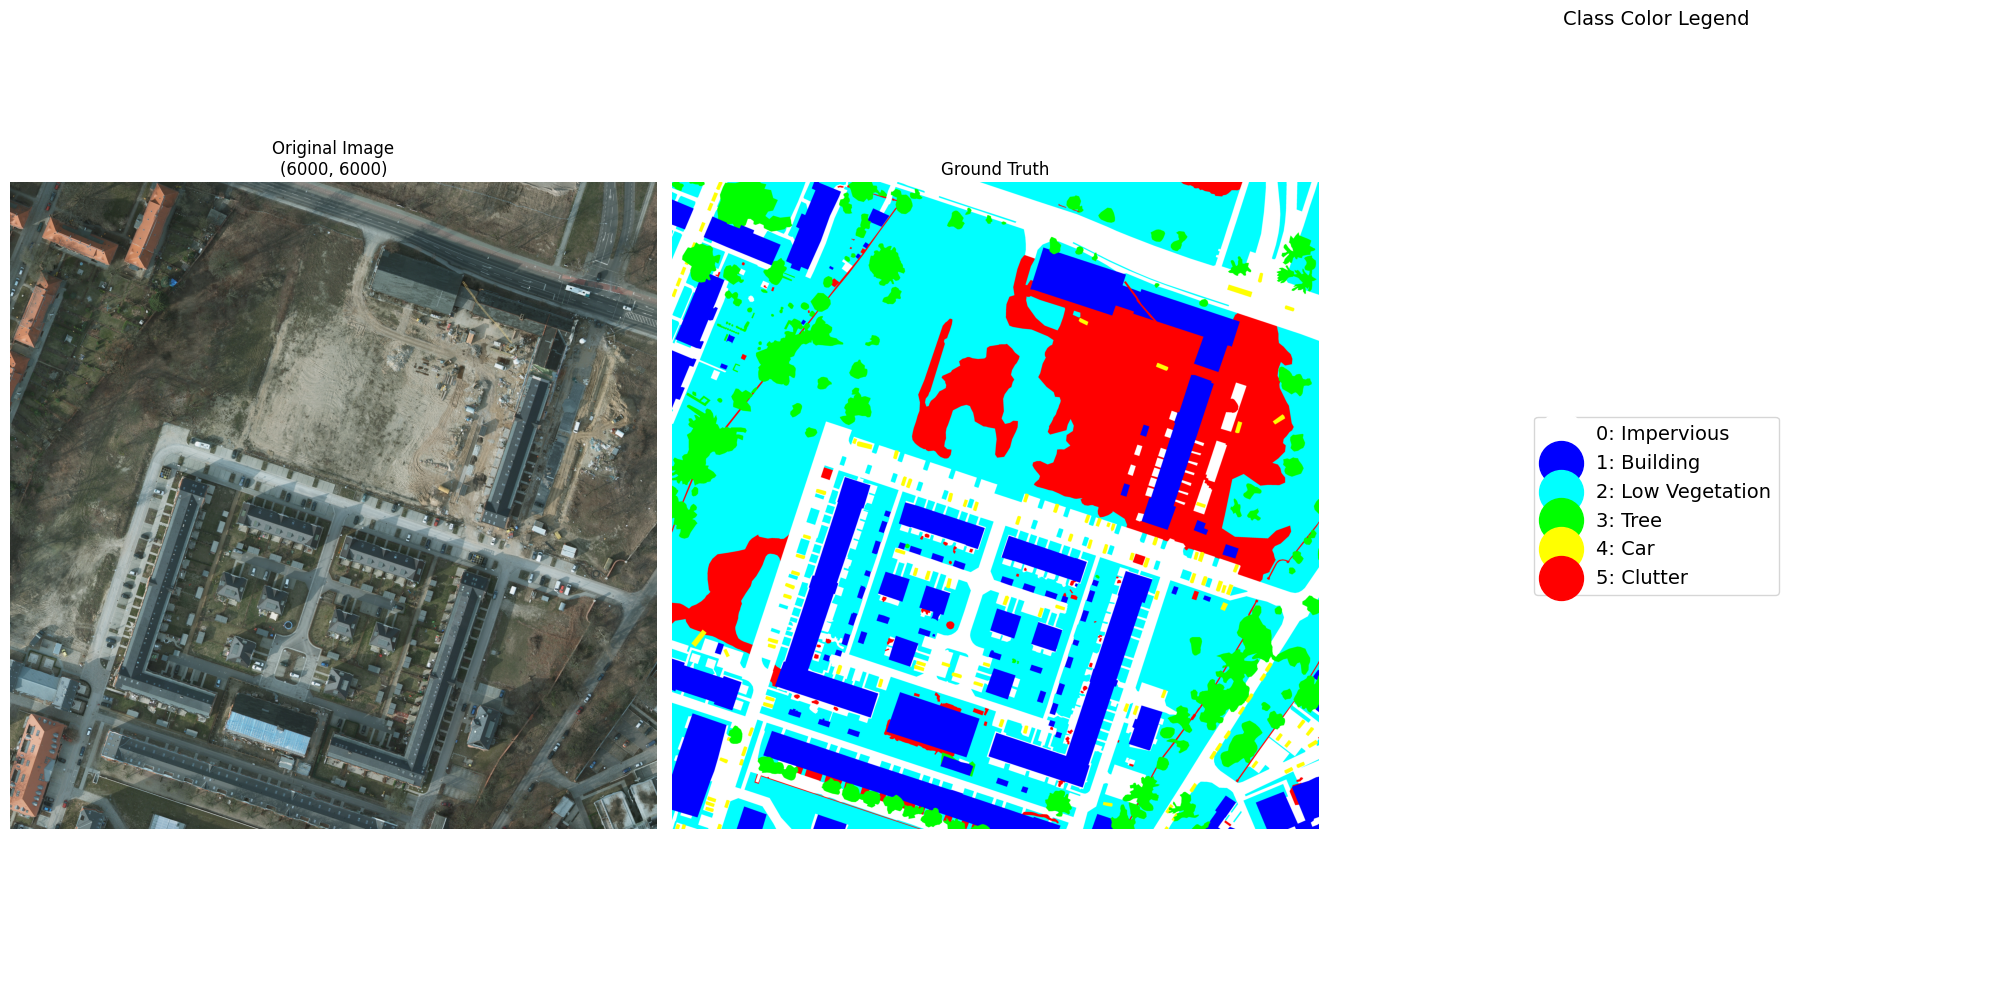

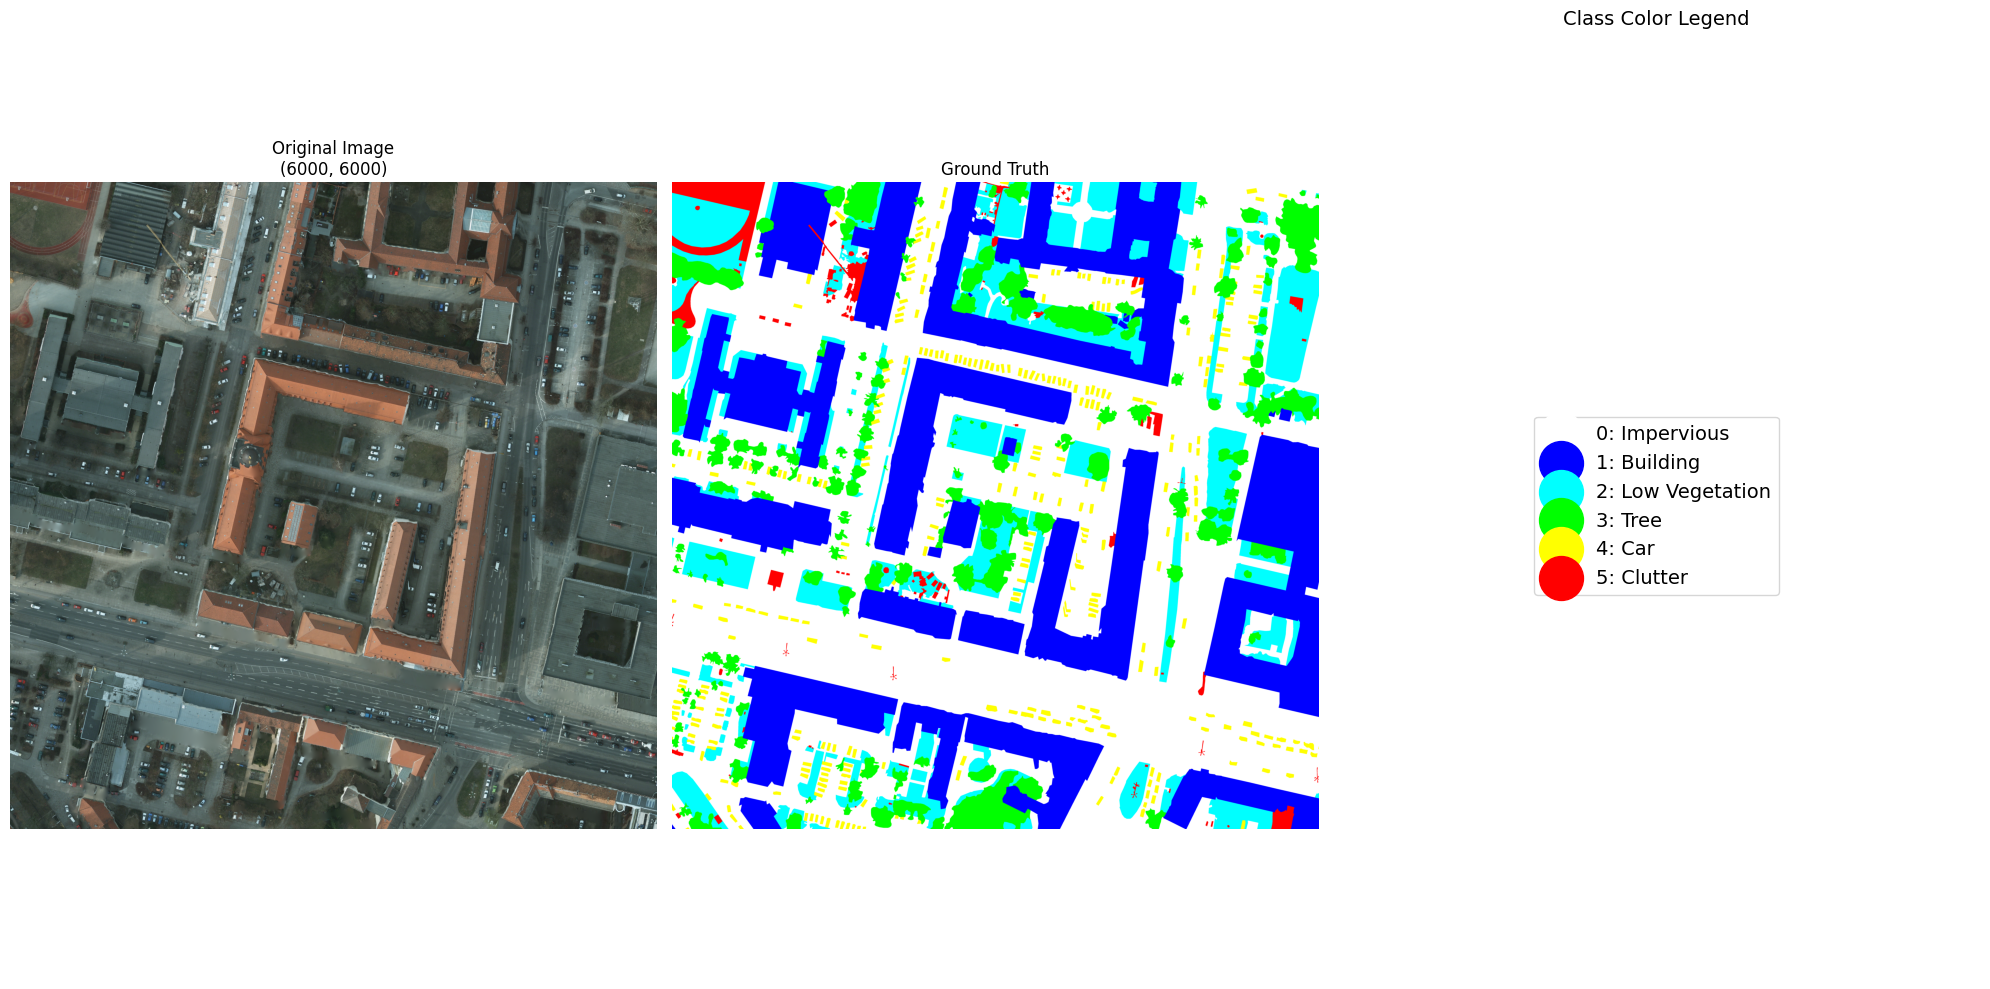

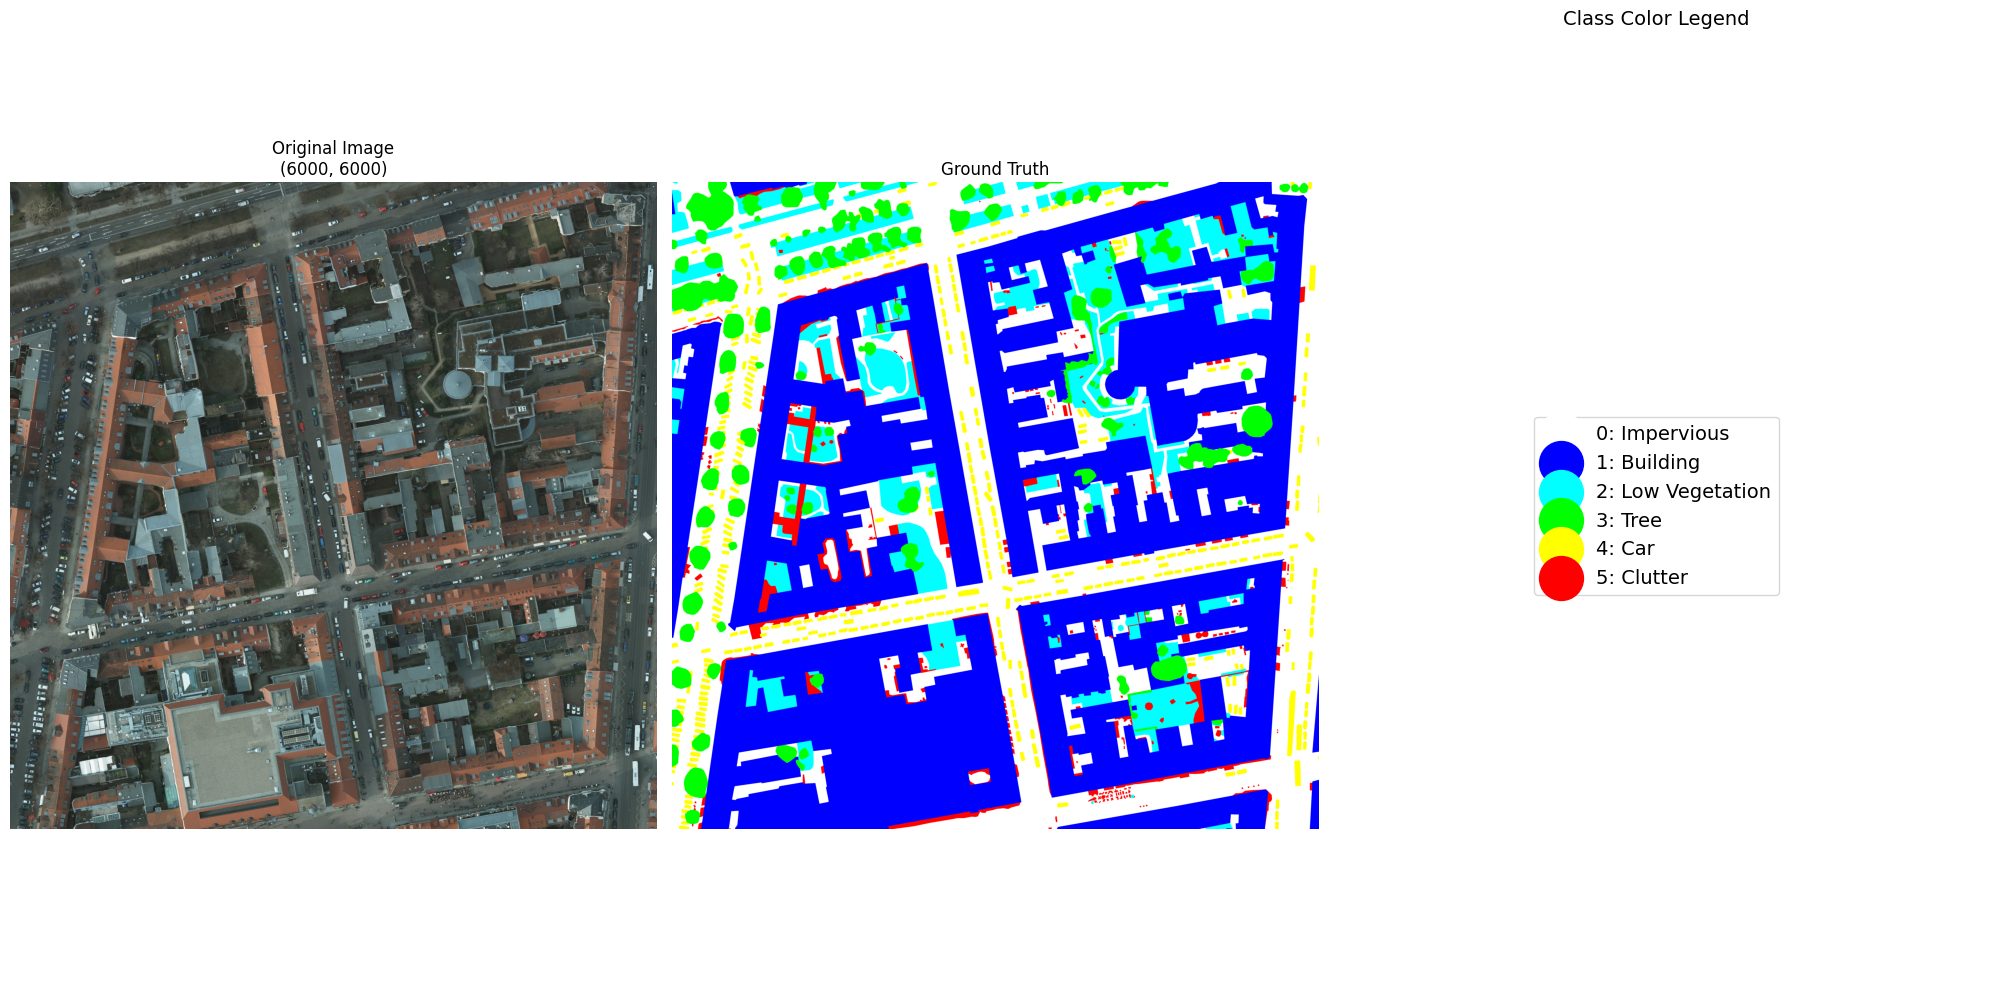

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

CLASS_COLORS = {
    0: ('Impervious', (255, 255, 255)),  
    1: ('Building', (0, 0, 255)),        
    2: ('Low Vegetation', (0, 255, 255)), 
    3: ('Tree', (0, 255, 0)),            
    4: ('Car', (255, 255, 0)),           
    5: ('Clutter', (255, 0, 0))          
}

def plot_original_pair(img_path, mask_path):
    img = np.array(Image.open(img_path).convert("RGB"))
    mask = np.array(Image.open(mask_path).convert("RGB"))
    
    plt.figure(figsize=(20, 10))
    
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title(f"Original Image\n{img.shape[:2]}", fontsize=12)
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask)
    plt.title("Ground Truth", fontsize=12)
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    for class_id, (name, color) in CLASS_COLORS.items():
        plt.scatter([], [], c=np.array(color)/255, s=1000, label=f"{class_id}: {name}")
    plt.legend(loc='center', prop={'size': 14})
    plt.axis('off')
    plt.title("Class Color Legend", fontsize=14)
    
    plt.tight_layout()
    plt.show()

sample_pairs = [
    ("/kaggle/input/potsdam/potsdam/images/top_potsdam_2_10_RGB.tif",
     "/kaggle/input/potsdam/potsdam/Labels/top_potsdam_2_10_label.tif"),
    
    ("/kaggle/input/potsdam/potsdam/images/top_potsdam_7_11_RGB.tif",
     "/kaggle/input/potsdam/potsdam/Labels/top_potsdam_7_11_label.tif"),
    
    ("/kaggle/input/potsdam/potsdam/images/top_potsdam_5_12_RGB.tif",
     "/kaggle/input/potsdam/potsdam/Labels/top_potsdam_5_12_label.tif")
]

for img_path, mask_path in sample_pairs:
    plot_original_pair(img_path, mask_path)

In [4]:
RAW_IMG_DIR = "/kaggle/input/potsdam/potsdam/images"
RAW_MASK_DIR = "/kaggle/input/potsdam/potsdam/Labels" 
PROCESSED_DIR = "/kaggle/working/processed"

In [5]:
os.makedirs(f"{PROCESSED_DIR}/images", exist_ok=True)
os.makedirs(f"{PROCESSED_DIR}/masks", exist_ok=True)

TILE_SIZE = 512  
STRIDE = 256    
FINAL_SIZE = 256 

def process_tile_pair(img_np, mask_np, prefix, count, x, y):
    """Crop and resize image-mask tile and save"""
    img_patch = img_np[y:y+TILE_SIZE, x:x+TILE_SIZE]
    mask_patch = mask_np[y:y+TILE_SIZE, x:x+TILE_SIZE]

    img_patch = Image.fromarray(img_patch).resize((FINAL_SIZE, FINAL_SIZE), Image.BILINEAR)
    mask_patch = Image.fromarray(mask_patch).resize((FINAL_SIZE, FINAL_SIZE), Image.NEAREST)

    img_patch.save(f"{PROCESSED_DIR}/images/{prefix}_{count}.png")
    mask_patch.save(f"{PROCESSED_DIR}/masks/{prefix}_{count}.png")

for img_file in tqdm(sorted(os.listdir(RAW_IMG_DIR))):
    if not img_file.endswith('_RGB.tif'):
        continue  
    
    mask_file = img_file.replace('_RGB.tif', '_label.tif')
    img_path = os.path.join(RAW_IMG_DIR, img_file)
    mask_path = os.path.join(RAW_MASK_DIR, mask_file)
    
    if not os.path.exists(mask_path):
        print(f" Mask not found: {mask_file}")
        continue
    
    image = np.array(Image.open(img_path).convert("RGB"))
    mask = np.array(Image.open(mask_path).convert("RGB"))
    
    if image.shape[:2] != mask.shape[:2]:
        print(f" Size mismatch: {img_file} vs {mask_file}")
        continue
   
    prefix = img_file.replace('_RGB.tif', '')
    count = 0
    for y in range(0, image.shape[0] - TILE_SIZE + 1, STRIDE):
        for x in range(0, image.shape[1] - TILE_SIZE + 1, STRIDE):
            process_tile_pair(image, mask, prefix, count, x, y)
            count += 1
    
    print(f" Processed {img_file} → {count} tiles")

print(f"\n All done! Tiles saved to:\n{PROCESSED_DIR}/images\n{PROCESSED_DIR}/masks")


  8%|▊         | 3/40 [00:21<04:29,  7.28s/it]

 Processed top_potsdam_2_10_RGB.tif → 484 tiles


 10%|█         | 4/40 [00:44<07:18, 12.17s/it]

 Processed top_potsdam_2_11_RGB.tif → 484 tiles


 12%|█▎        | 5/40 [01:07<09:12, 15.79s/it]

 Processed top_potsdam_2_12_RGB.tif → 484 tiles


 15%|█▌        | 6/40 [01:31<10:20, 18.26s/it]

 Processed top_potsdam_2_13_RGB.tif → 484 tiles


 18%|█▊        | 7/40 [01:54<10:48, 19.66s/it]

 Processed top_potsdam_2_14_RGB.tif → 484 tiles


 20%|██        | 8/40 [02:19<11:17, 21.18s/it]

 Processed top_potsdam_3_10_RGB.tif → 484 tiles


 22%|██▎       | 9/40 [02:44<11:32, 22.34s/it]

 Processed top_potsdam_3_11_RGB.tif → 484 tiles


 25%|██▌       | 10/40 [03:08<11:32, 23.10s/it]

 Processed top_potsdam_3_12_RGB.tif → 484 tiles


 28%|██▊       | 11/40 [03:33<11:26, 23.67s/it]

 Processed top_potsdam_3_13_RGB.tif → 484 tiles


 30%|███       | 12/40 [03:58<11:09, 23.90s/it]

 Processed top_potsdam_3_14_RGB.tif → 484 tiles


 32%|███▎      | 13/40 [04:22<10:49, 24.04s/it]

 Processed top_potsdam_4_10_RGB.tif → 484 tiles


 35%|███▌      | 14/40 [04:48<10:36, 24.48s/it]

 Processed top_potsdam_4_11_RGB.tif → 484 tiles


 38%|███▊      | 15/40 [05:24<11:41, 28.05s/it]

 Processed top_potsdam_4_12_RGB.tif → 484 tiles


 40%|████      | 16/40 [05:50<10:55, 27.32s/it]

 Processed top_potsdam_4_13_RGB.tif → 484 tiles


 42%|████▎     | 17/40 [06:15<10:11, 26.57s/it]

 Processed top_potsdam_4_14_RGB.tif → 484 tiles


 45%|████▌     | 18/40 [06:40<09:36, 26.19s/it]

 Processed top_potsdam_4_15_RGB.tif → 484 tiles


 48%|████▊     | 19/40 [07:07<09:13, 26.34s/it]

 Processed top_potsdam_5_10_RGB.tif → 484 tiles


 50%|█████     | 20/40 [07:33<08:45, 26.26s/it]

 Processed top_potsdam_5_11_RGB.tif → 484 tiles


 52%|█████▎    | 21/40 [07:56<08:03, 25.45s/it]

 Processed top_potsdam_5_12_RGB.tif → 484 tiles


 55%|█████▌    | 22/40 [08:22<07:42, 25.67s/it]

 Processed top_potsdam_5_13_RGB.tif → 484 tiles


 57%|█████▊    | 23/40 [08:48<07:15, 25.62s/it]

 Processed top_potsdam_5_14_RGB.tif → 484 tiles


 60%|██████    | 24/40 [09:13<06:46, 25.41s/it]

 Processed top_potsdam_5_15_RGB.tif → 484 tiles


 62%|██████▎   | 25/40 [09:39<06:22, 25.52s/it]

 Processed top_potsdam_6_10_RGB.tif → 484 tiles


 65%|██████▌   | 26/40 [10:04<05:56, 25.49s/it]

 Processed top_potsdam_6_11_RGB.tif → 484 tiles


 68%|██████▊   | 27/40 [10:29<05:31, 25.46s/it]

 Processed top_potsdam_6_12_RGB.tif → 484 tiles


 70%|███████   | 28/40 [10:55<05:07, 25.63s/it]

 Processed top_potsdam_6_13_RGB.tif → 484 tiles


 72%|███████▎  | 29/40 [11:21<04:41, 25.58s/it]

 Processed top_potsdam_6_14_RGB.tif → 484 tiles


 75%|███████▌  | 30/40 [11:46<04:14, 25.49s/it]

 Processed top_potsdam_6_15_RGB.tif → 484 tiles


 78%|███████▊  | 31/40 [12:10<03:44, 24.89s/it]

 Processed top_potsdam_6_7_RGB.tif → 484 tiles


 80%|████████  | 32/40 [12:35<03:19, 24.97s/it]

 Processed top_potsdam_6_8_RGB.tif → 484 tiles


 82%|████████▎ | 33/40 [12:59<02:54, 24.87s/it]

 Processed top_potsdam_6_9_RGB.tif → 484 tiles


 85%|████████▌ | 34/40 [13:25<02:30, 25.17s/it]

 Processed top_potsdam_7_10_RGB.tif → 484 tiles


 88%|████████▊ | 35/40 [13:49<02:04, 24.86s/it]

 Processed top_potsdam_7_11_RGB.tif → 484 tiles


 90%|█████████ | 36/40 [14:14<01:39, 24.78s/it]

 Processed top_potsdam_7_12_RGB.tif → 484 tiles


 92%|█████████▎| 37/40 [14:39<01:14, 24.95s/it]

 Processed top_potsdam_7_13_RGB.tif → 484 tiles


 95%|█████████▌| 38/40 [15:05<00:50, 25.26s/it]

 Processed top_potsdam_7_7_RGB.tif → 484 tiles


 98%|█████████▊| 39/40 [15:31<00:25, 25.50s/it]

 Processed top_potsdam_7_8_RGB.tif → 484 tiles


100%|██████████| 40/40 [15:56<00:00, 23.92s/it]

 Processed top_potsdam_7_9_RGB.tif → 484 tiles

 All done! Tiles saved to:
/kaggle/working/processed/images
/kaggle/working/processed/masks


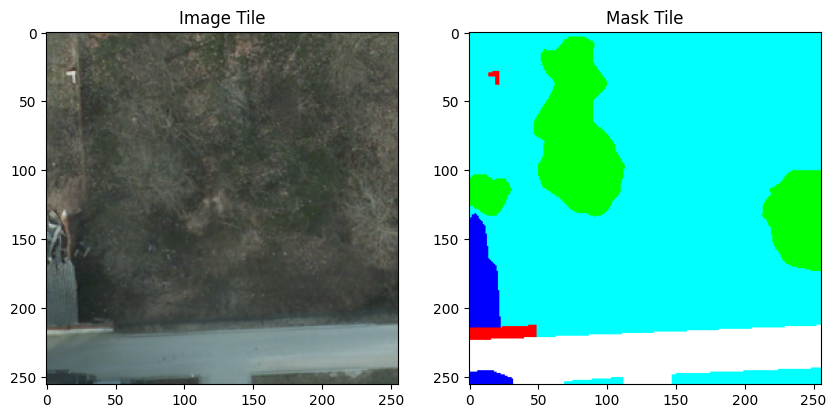

In [6]:

img = Image.open(f"{PROCESSED_DIR}/images/top_potsdam_4_10_2.png")
mask = Image.open(f"{PROCESSED_DIR}/masks/top_potsdam_4_10_2.png")

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(img); plt.title("Image Tile")
plt.subplot(1,2,2); plt.imshow(mask); plt.title("Mask Tile")
plt.show()

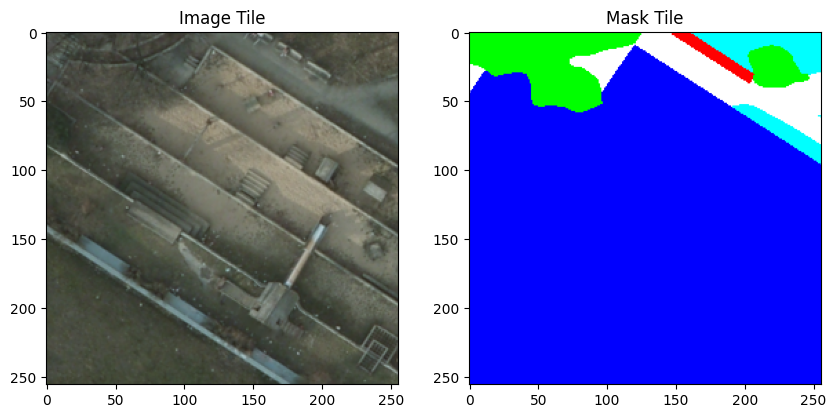

In [7]:
img = Image.open(f"{PROCESSED_DIR}/images/top_potsdam_7_10_8.png")
mask = Image.open(f"{PROCESSED_DIR}/masks/top_potsdam_7_10_8.png")

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(img); plt.title("Image Tile")
plt.subplot(1,2,2); plt.imshow(mask); plt.title("Mask Tile")
plt.show()

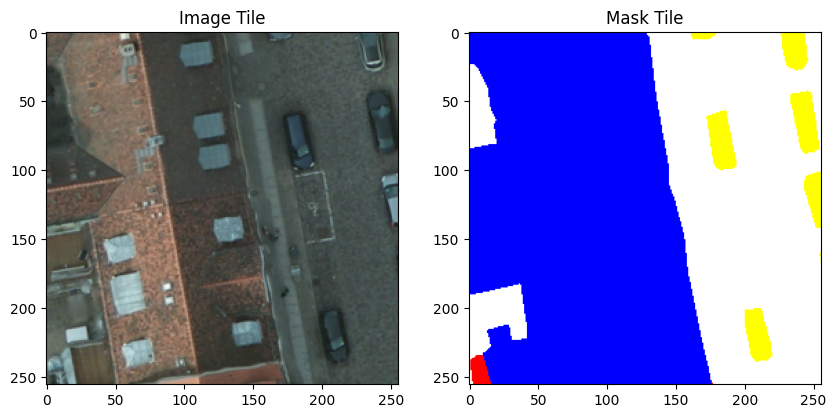

In [8]:
img = Image.open(f"{PROCESSED_DIR}/images/top_potsdam_6_11_2.png")
mask = Image.open(f"{PROCESSED_DIR}/masks/top_potsdam_6_11_2.png")

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(img); plt.title("Image Tile")
plt.subplot(1,2,2); plt.imshow(mask); plt.title("Mask Tile")
plt.show()

In [9]:

MASK_DIR = "/kaggle/working/processed/masks"  
OUTPUT_DIR = "/kaggle/working/masks_converted"

COLOR_MAP = {
    (255, 255, 255): 0,  # Impervious
    (0, 0, 255): 1,      # Building
    (0, 255, 255): 2,    # Low Vegetation
    (0, 255, 0): 3,      # Tree
    (255, 255, 0): 4,    # Car
    (255, 0, 0): 5       # Clutter
}

def rgb_to_class_index(mask_rgb):
    """FAST vectorized conversion (original version)"""
    h, w, _ = mask_rgb.shape
    mask_index = np.zeros((h, w), dtype=np.uint8)
    
    for rgb, idx in COLOR_MAP.items():
        match = np.all(mask_rgb == rgb, axis=-1)
        mask_index[match] = idx
        
    return mask_index

def convert_all_masks():
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    files = [f for f in sorted(os.listdir(MASK_DIR)) if f.endswith('.png')]
    
    print(f"Converting {len(files)} masks...")
    for file in tqdm(files, desc="Processing"):
        mask_path = os.path.join(MASK_DIR, file)
        mask_rgb = np.array(Image.open(mask_path).convert("RGB"))
        mask_class = rgb_to_class_index(mask_rgb)
        Image.fromarray(mask_class).save(os.path.join(OUTPUT_DIR, file))
    
    print(f" Conversion complete! Saved to {OUTPUT_DIR}")

import shutil
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)
    


In [10]:
convert_all_masks()

Converting 18392 masks...


Processing: 100%|██████████| 18392/18392 [04:07<00:00, 74.42it/s]

 Conversion complete! Saved to /kaggle/working/masks_converted


In [11]:

class PotsdamDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        
        self.files = sorted([f for f in os.listdir(images_dir) if f.endswith('.png')])
        
        if not self.files:
            raise FileNotFoundError(f"No PNG images found in {images_dir}")
        if not os.path.exists(masks_dir):
            raise FileNotFoundError(f"Masks directory {masks_dir} not found")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.files[idx])
        mask_path = os.path.join(self.masks_dir, self.files[idx])  # Same filename
        
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path)
        
        if self.transform:
            image = self.transform(image)
            
        mask = torch.from_numpy(np.array(mask)).long()  # Critical for CrossEntropy
        
        return image, mask

    @staticmethod
    def get_transforms():
        return T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
        ])

In [12]:
transform = PotsdamDataset.get_transforms()
dataset = PotsdamDataset(
    images_dir="/kaggle/working/processed/images",
    masks_dir="/kaggle/working/masks_converted",
    transform=transform
)

image, mask = dataset[0]
print(f"Image shape: {image.shape}")  
print(f"Mask shape: {mask.shape}")    

Image shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])


In [20]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c, act=True):
        super().__init__()
        layers = [nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)]
        if act:
            layers.append(nn.BatchNorm2d(out_c))
            layers.append(nn.ReLU(inplace=True))
        self.conv = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.conv(x)

In [21]:
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c, act=True):
        super().__init__()
        self.c1 = nn.Sequential(
            conv_block(in_c, out_c, act=act),
            conv_block(out_c, out_c, act=act),
        )
        self.p1 = nn.MaxPool2d(2)
    
    def forward(self, x):
        x = self.c1(x)
        p = self.p1(x)
        return x, p

In [22]:
class UNet3Plus(nn.Module):
    def __init__(self, num_classes=6, deep_sup=False, base_channels=32):
        super().__init__()
        self.deep_sup = deep_sup

        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        self.e5 = nn.Sequential(
            conv_block(512, 1024),
            conv_block(1024, 512),
        )

        self.e1_d4 = conv_block(64, base_channels)
        self.e2_d4 = conv_block(128, base_channels)
        self.e3_d4 = conv_block(256, base_channels)
        self.e4_d4 = conv_block(512, base_channels)
        self.e5_d4 = conv_block(512, base_channels)
        self.d4 = conv_block(base_channels * 5, base_channels)

        self.e1_d3 = conv_block(64, base_channels)
        self.e2_d3 = conv_block(128, base_channels)
        self.e3_d3 = conv_block(256, base_channels)
        self.e4_d3 = conv_block(base_channels, base_channels)
        self.e5_d3 = conv_block(512, base_channels)
        self.d3 = conv_block(base_channels * 5, base_channels)

        self.e1_d2 = conv_block(64, base_channels)
        self.e2_d2 = conv_block(128, base_channels)
        self.e3_d2 = conv_block(base_channels, base_channels)
        self.e4_d2 = conv_block(base_channels, base_channels)
        self.e5_d2 = conv_block(512, base_channels)
        self.d2 = conv_block(base_channels * 5, base_channels)

        self.e1_d1 = conv_block(64, base_channels)
        self.e2_d1 = conv_block(base_channels, base_channels)
        self.e3_d1 = conv_block(base_channels, base_channels)
        self.e4_d1 = conv_block(base_channels, base_channels)
        self.e5_d1 = conv_block(512, base_channels)
        self.d1 = conv_block(base_channels * 5, base_channels)

        self.y1 = nn.Conv2d(base_channels, num_classes, kernel_size=3, padding=1)
        
        if deep_sup:
            self.y2 = nn.Conv2d(base_channels, num_classes, kernel_size=3, padding=1)
            self.y3 = nn.Conv2d(base_channels, num_classes, kernel_size=3, padding=1)
            self.y4 = nn.Conv2d(base_channels, num_classes, kernel_size=3, padding=1)
            self.y5 = nn.Conv2d(512, num_classes, kernel_size=3, padding=1)

    def _forward_impl(self, x):
        e1, p1 = self.e1(x)
        e2, p2 = self.e2(p1)
        e3, p3 = self.e3(p2)
        e4, p4 = self.e4(p3)
        e5 = self.e5(p4)

        if not self.deep_sup:
            e1_d4 = self.e1_d4(F.max_pool2d(e1, 8))
            e2_d4 = self.e2_d4(F.max_pool2d(e2, 4))
            e3_d4 = self.e3_d4(F.max_pool2d(e3, 2))
            e4_d4 = self.e4_d4(e4)
            e5_d4 = self.e5_d4(F.interpolate(e5, scale_factor=2, mode='bilinear', align_corners=False))
            d4 = self.d4(torch.cat([e1_d4, e2_d4, e3_d4, e4_d4, e5_d4], dim=1))

            e1_d3 = self.e1_d3(F.max_pool2d(e1, 4))
            e2_d3 = self.e2_d3(F.max_pool2d(e2, 2))
            e3_d3 = self.e3_d3(e3)
            e4_d3 = self.e4_d3(F.interpolate(d4, scale_factor=2, mode='bilinear', align_corners=False))
            e5_d3 = self.e5_d3(F.interpolate(e5, scale_factor=4, mode='bilinear', align_corners=False))
            d3 = self.d3(torch.cat([e1_d3, e2_d3, e3_d3, e4_d3, e5_d3], dim=1))

            e1_d2 = self.e1_d2(F.max_pool2d(e1, 2))
            e2_d2 = self.e2_d2(e2)
            e3_d2 = self.e3_d2(F.interpolate(d3, scale_factor=2, mode='bilinear', align_corners=False))
            e4_d2 = self.e4_d2(F.interpolate(d4, scale_factor=4, mode='bilinear', align_corners=False))
            e5_d2 = self.e5_d2(F.interpolate(e5, scale_factor=8, mode='bilinear', align_corners=False))
            d2 = self.d2(torch.cat([e1_d2, e2_d2, e3_d2, e4_d2, e5_d2], dim=1))

            e1_d1 = self.e1_d1(e1)
            e2_d1 = self.e2_d1(F.interpolate(d2, scale_factor=2, mode='bilinear', align_corners=False))
            e3_d1 = self.e3_d1(F.interpolate(d3, scale_factor=4, mode='bilinear', align_corners=False))
            e4_d1 = self.e4_d1(F.interpolate(d4, scale_factor=8, mode='bilinear', align_corners=False))
            e5_d1 = self.e5_d1(F.interpolate(e5, scale_factor=16, mode='bilinear', align_corners=False))
            d1 = self.d1(torch.cat([e1_d1, e2_d1, e3_d1, e4_d1, e5_d1], dim=1))
            
            return self.y1(d1)

        e1_d4 = self.e1_d4(F.max_pool2d(e1, 8))
        e2_d4 = self.e2_d4(F.max_pool2d(e2, 4))
        e3_d4 = self.e3_d4(F.max_pool2d(e3, 2))
        e4_d4 = self.e4_d4(e4)
        e5_d4 = self.e5_d4(F.interpolate(e5, scale_factor=2, mode='bilinear', align_corners=False))
        d4 = self.d4(torch.cat([e1_d4, e2_d4, e3_d4, e4_d4, e5_d4], dim=1))

        e1_d3 = self.e1_d3(F.max_pool2d(e1, 4))
        e2_d3 = self.e2_d3(F.max_pool2d(e2, 2))
        e3_d3 = self.e3_d3(e3)
        e4_d3 = self.e4_d3(F.interpolate(d4, scale_factor=2, mode='bilinear', align_corners=False))
        e5_d3 = self.e5_d3(F.interpolate(e5, scale_factor=4, mode='bilinear', align_corners=False))
        d3 = self.d3(torch.cat([e1_d3, e2_d3, e3_d3, e4_d3, e5_d3], dim=1))

        e1_d2 = self.e1_d2(F.max_pool2d(e1, 2))
        e2_d2 = self.e2_d2(e2)
        e3_d2 = self.e3_d2(F.interpolate(d3, scale_factor=2, mode='bilinear', align_corners=False))
        e4_d2 = self.e4_d2(F.interpolate(d4, scale_factor=4, mode='bilinear', align_corners=False))
        e5_d2 = self.e5_d2(F.interpolate(e5, scale_factor=8, mode='bilinear', align_corners=False))
        d2 = self.d2(torch.cat([e1_d2, e2_d2, e3_d2, e4_d2, e5_d2], dim=1))

        e1_d1 = self.e1_d1(e1)
        e2_d1 = self.e2_d1(F.interpolate(d2, scale_factor=2, mode='bilinear', align_corners=False))
        e3_d1 = self.e3_d1(F.interpolate(d3, scale_factor=4, mode='bilinear', align_corners=False))
        e4_d1 = self.e4_d1(F.interpolate(d4, scale_factor=8, mode='bilinear', align_corners=False))
        e5_d1 = self.e5_d1(F.interpolate(e5, scale_factor=16, mode='bilinear', align_corners=False))
        d1 = self.d1(torch.cat([e1_d1, e2_d1, e3_d1, e4_d1, e5_d1], dim=1))

        y1 = self.y1(d1)
        y2 = F.interpolate(self.y2(d2), scale_factor=2, mode="bilinear", align_corners=False)
        y3 = F.interpolate(self.y3(d3), scale_factor=4, mode="bilinear", align_corners=False)
        y4 = F.interpolate(self.y4(d4), scale_factor=8, mode="bilinear", align_corners=False)
        y5 = F.interpolate(self.y5(e5), scale_factor=16, mode="bilinear", align_corners=False)

        return y1, y2, y3, y4, y5

    def forward(self, x):
        #if self.training:
            #return torch.utils.checkpoint.checkpoint(self._forward_impl, x)
        #else:
            return self._forward_impl(x)

In [68]:
BATCH_SIZE = 16    
EPOCHS = 50
LR = 1e-4
NUM_CLASSES = 6
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


In [69]:
DEVICE

'cuda'

In [70]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


In [71]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

In [72]:
model = UNet3Plus(num_classes=6, deep_sup=False, base_channels=32).to(DEVICE)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs with DataParallel")
    model = torch.nn.DataParallel(model)

Using 2 GPUs with DataParallel


In [73]:
model

DataParallel(
  (module): UNet3Plus(
    (e1): encoder_block(
      (c1): Sequential(
        (0): conv_block(
          (conv): Sequential(
            (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
        )
        (1): conv_block(
          (conv): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
        )
      )
      (p1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (e2): encoder_block(
      (c1): Sequential(
        (0): conv_block(
          (conv): Sequential(
            (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(128, eps=1e

In [74]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
scaler = GradScaler()

/tmp/ipykernel_36/3292922129.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [75]:
train_losses, train_ious, train_dices = [], [], []
val_ious, val_dices = [], []

In [76]:
train_iou_metric = MulticlassJaccardIndex(num_classes=NUM_CLASSES).to(DEVICE)
train_dice_metric = DiceScore(num_classes=NUM_CLASSES).to(DEVICE)
val_iou_metric = MulticlassJaccardIndex(num_classes=NUM_CLASSES).to(DEVICE)
val_dice_metric = DiceScore(num_classes=NUM_CLASSES).to(DEVICE)


In [77]:
def training(model, loader, criterion, optimizer, scaler):
    model.train()
    total_loss = 0
    train_iou_metric.reset()
    train_dice_metric.reset()

    for images, masks in loader:
        images = images.float().to(DEVICE)
        masks = masks.long().to(DEVICE)
        optimizer.zero_grad()

        with autocast():  
            outputs = model(images)
            if isinstance(outputs, (tuple, list)):
                outputs = outputs[0]
            loss = criterion(outputs, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        train_iou_metric.update(preds, masks)
        train_dice_metric.update(preds, masks)

    avg_loss = total_loss / len(loader)
    avg_iou = train_iou_metric.compute().item()
    avg_dice = train_dice_metric.compute().item()
    return avg_loss, avg_iou, avg_dice


In [78]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    val_iou_metric.reset()
    val_dice_metric.reset()
    
    for images, masks in loader:
        torch.cuda.empty_cache()
        
        images, masks = images.to(DEVICE, non_blocking=True), masks.to(DEVICE, non_blocking=True)
        
        with autocast():
            outputs = model(images)
            if isinstance(outputs, (tuple, list)):
                outputs = outputs[0]
            preds = torch.argmax(outputs, dim=1)
        
        val_iou_metric.update(preds, masks)
        val_dice_metric.update(preds, masks)
        
        del outputs, preds
        torch.cuda.empty_cache()
    
    avg_iou = val_iou_metric.compute().item()
    avg_dice = val_dice_metric.compute().item()
    return avg_iou, avg_dice


In [79]:

def save_checkpoint(model, optimizer, scaler, epoch, path="checkpoint.pth"):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scaler_state_dict': scaler.state_dict(),
        'epoch': epoch,
    }
    torch.save(checkpoint, path)
    print(f"Checkpoint saved at epoch {epoch}")

def load_checkpoint(model, optimizer, scaler, path="checkpoint.pth"):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scaler.load_state_dict(checkpoint['scaler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Checkpoint loaded, resuming from epoch {start_epoch}")
    return start_epoch


In [ ]:
CHECKPOINT_DIR = "./checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

for epoch in trange(EPOCHS, desc="Epochs", dynamic_ncols=True, leave=True):
    torch.cuda.empty_cache()
    
    train_loss, train_iou, train_dice = training(model, train_loader, criterion, optimizer, scaler)
    val_iou, val_dice = evaluate(model, val_loader)
    
    train_losses.append(train_loss)
    train_ious.append(train_iou)
    train_dices.append(train_dice)
    val_ious.append(val_iou)
    val_dices.append(val_dice)
    
    print(f"Epoch [{epoch+1}/{EPOCHS}]")
    print(f"  Loss: {train_loss:.4f}")
    print(f"  Train IoU: {train_iou:.4f}, Train Dice: {train_dice:.4f}")
    print(f"  Val IoU: {val_iou:.4f}, Val Dice: {val_dice:.4f}")
    
    if (epoch + 1) % 10 == 0:
        checkpoint_path = os.path.join(CHECKPOINT_DIR, f"checkpoint_epoch_{epoch+1}.pth")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scaler_state_dict': scaler.state_dict(),
            'train_losses': train_losses,
            'train_ious': train_ious,
            'train_dices': train_dices,
            'val_ious': val_ious,
            'val_dices': val_dices,
        }, checkpoint_path)
        print(f"Checkpoint saved: {checkpoint_path}")

print("Training finished!")

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_36/1629212038.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
